# L3 SWOT SSH Field filtering in space and time 

#### Imports

In [1]:
import os
import sys


import numpy as np
import xarray as xr

from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter


sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *
from L3Field_filtering import *

import matplotlib
from matplotlib import pyplot as plt


path_fields = '../save_data/fields_data'
path_save_plot = '../save_plots/save_plots_2024-07-01_L3Fields_filtering'

# Load data

In [3]:
ds = xr.open_dataset(os.path.join(path_fields, 'field_L3SWOT.nc'))
lon = ds.longitude
lat = ds.latitude
ds

<xarray.Dataset>
Dimensions:    (time: 90, y: 399, x: 69)
Coordinates:
  * time       (time) datetime64[ns] 2023-03-30T00:12:09 ... 2023-07-09T08:16:31
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    ssh        (time, y, x) float32 ...
    u_geos     (time, y, x) float32 ...
    v_geos     (time, y, x) float32 ...
    u_var      (time, y, x) float32 ...
    v_var      (time, y, x) float32 ...
Attributes:
    DATAPRODUCT:   L3SWOT_20240626
    gridtype_adt:  T grid : (latitude, longitude)
    gridtype_uv:   U/V grid

# One time spatial filter 

In [4]:
i = 30
smoothed_ssh = apply_space_gaussianfilter(ds.longitude.values, ds.latitude.values, ds.ssh.values[i], sigma=5)

Text(0, 0.5, 'Latitude')

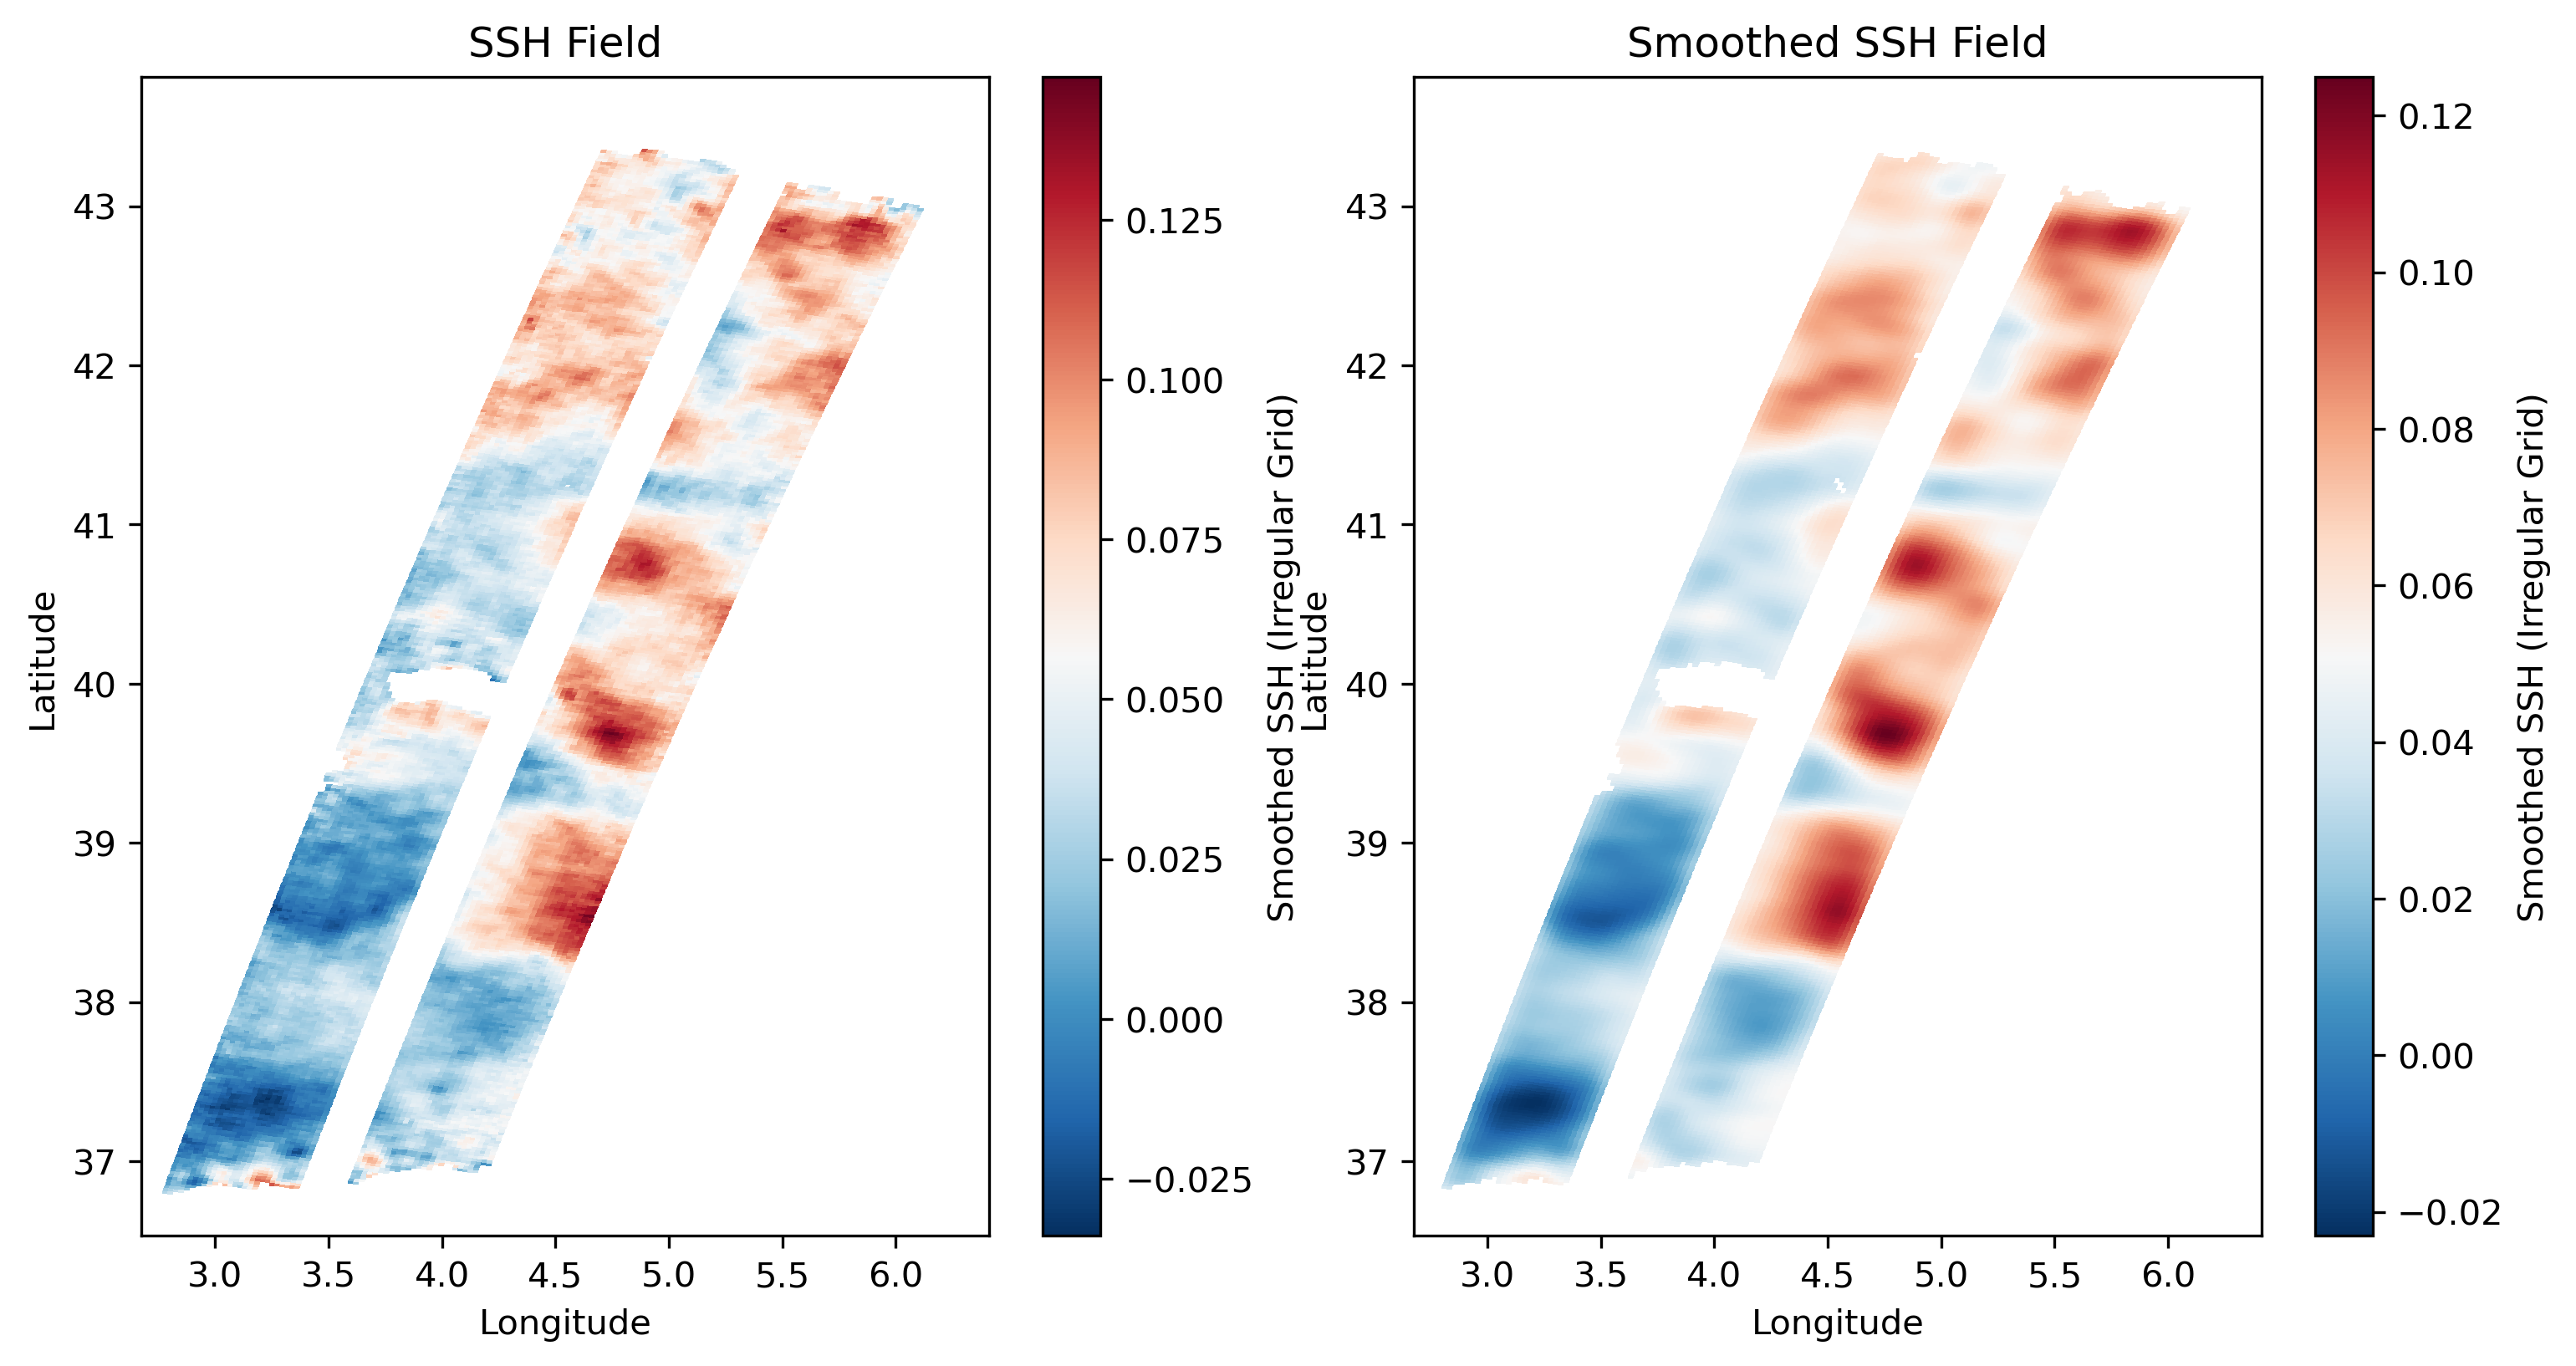

In [5]:

matplotlib.rcParams['figure.dpi'] = 300
latitudes = ds.latitude.values.flatten()
longitudes = ds.longitude.values.flatten()

plt.figure(figsize=(12, 6))

# Original SSH Field on Irregular Grid
plt.subplot(1, 2, 1)
plt.pcolormesh(ds.longitude, ds.latitude, ds.ssh[i], cmap='RdBu_r')
plt.colorbar(label='Smoothed SSH (Irregular Grid)')
plt.title('SSH Field')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(1, 2, 2)
plt.pcolormesh(ds.longitude, ds.latitude, smoothed_ssh, cmap='RdBu_r')
plt.colorbar(label='Smoothed SSH (Irregular Grid)')
plt.title('Smoothed SSH Field')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [10]:
dlat, dlon

NameError: name 'dlat' is not defined

In [77]:
120/72

1.6666666666666667

In [149]:
km_pxlat = 0.035 /360 *6400*2*np.pi
print('km per pixel in latitude', km_pxlat)
2 / km_pxlat

km per pixel in latitude 3.9095375244672983


0.511569459938235

### applying for all times

In [9]:
filtered_data = xr.apply_ufunc(
    apply_space_gaussianfilter,
    ds.longitude, ds.latitude, ds.ssh,
    input_core_dims=[['y', 'x'], ['y', 'x'], ['y', 'x']],
    output_core_dims=[['y', 'x']],
    kwargs={'sigma': 2},
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

KeyboardInterrupt: 

# Temporal filter

In [4]:
ds

<xarray.Dataset>
Dimensions:    (time: 90, y: 399, x: 69)
Coordinates:
  * time       (time) datetime64[ns] 2023-03-30T00:12:09 ... 2023-07-09T08:16:31
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    ssh        (time, y, x) float32 ...
    u_geos     (time, y, x) float32 ...
    v_geos     (time, y, x) float32 ...
    u_var      (time, y, x) float32 ...
    v_var      (time, y, x) float32 ...
Attributes:
    DATAPRODUCT:   L3SWOT_20240626
    gridtype_adt:  T grid : (latitude, longitude)
    gridtype_uv:   U/V grid

In [5]:
a = ds.time.values
(a[1:] - a[:-1]).astype(np.float64) /1e9 /3600

array([23.84361111, 47.68777778, 23.84388889, 23.84388889, 23.84361111,
       23.84388889, 23.84388889, 23.84388889, 23.84416667, 23.84388889,
       23.84388889, 23.84388889, 23.84388889, 23.84388889, 23.84388889,
       23.84388889, 23.84388889, 23.84388889, 23.84361111, 23.84388889,
       23.84388889, 47.68777778, 23.84388889, 23.84388889, 23.84388889,
       23.84388889, 23.84361111, 23.84388889, 23.84388889, 23.84388889,
       23.84388889, 23.84361111, 23.84388889, 23.84388889, 23.84361111,
       23.84388889, 23.84388889, 23.84388889, 23.84388889, 23.84361111,
       23.84388889, 23.84388889, 23.84361111, 23.84388889, 23.84388889,
       23.84361111, 23.84388889, 23.84388889, 95.37555556, 23.84388889,
       23.84388889, 23.84388889, 23.84388889, 23.84361111, 47.68777778,
       23.84388889, 47.6875    , 23.84388889, 23.84388889, 23.84388889,
       47.68777778, 23.84388889, 23.84361111, 23.84388889, 23.84388889,
       23.84388889, 23.84361111, 23.84388889, 23.84388889, 23.84

In [21]:
# Choose the standard deviation for the Gaussian kernel
sigma = 24 # hours

# Apply the Gaussian filter along the time dimension
sanitize_data = ds.copy(deep=True)

nan_mask = np.isnan(sanitize_data['ssh'])

# Replace NaN values with 0
sanitize_data = sanitize_data.fillna(0)

filtered_data = xr.apply_ufunc(
    apply_time_gaussianfilter,
    sanitize_data.time,
    sanitize_data.ssh,
    input_core_dims=[['time'], ['time']],
    output_core_dims=[['time']],
    kwargs={'sigma': sigma},
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float],
)

filtered_data = xr.where(nan_mask, np.nan, filtered_data)

In [7]:
filtered_data.shape

(90, 399, 69)

In [8]:
ds.time[75]

<xarray.DataArray 'time' ()>
array('2023-06-20T11:14:30.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2023-06-20T11:14:30

Text(0, 0.5, 'Latitude')

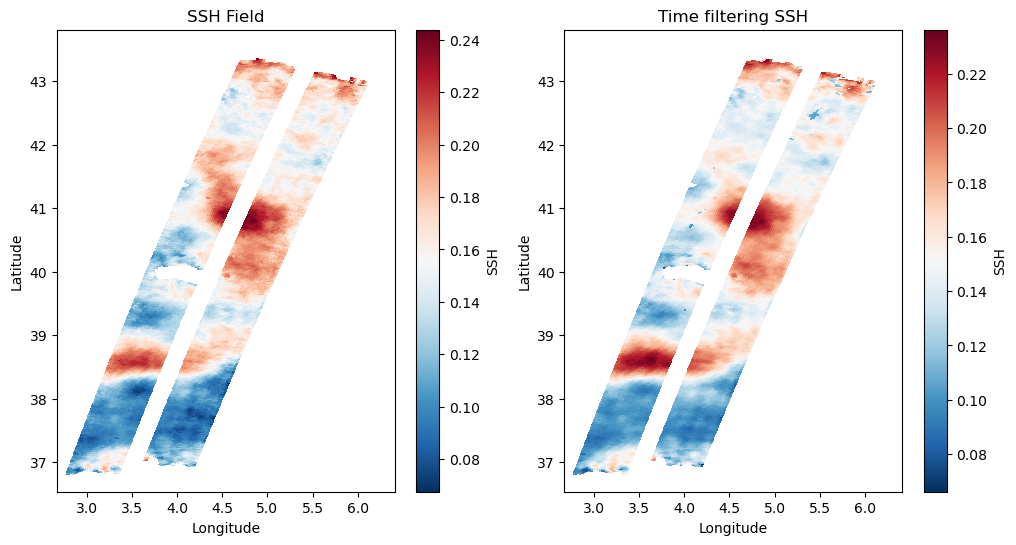

In [22]:
plt.figure(figsize=(12, 6))

i = 76

# Original SSH Field on Irregular Grid
plt.subplot(1, 2, 1)
plt.pcolormesh(ds.longitude, ds.latitude, ds.ssh.values[i], cmap='RdBu_r')
plt.colorbar(label='SSH')
plt.title('SSH Field')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(1, 2, 2)
plt.pcolormesh(filtered_data.longitude, filtered_data.latitude, filtered_data.values[i], cmap='RdBu_r')
plt.colorbar(label='SSH')
plt.title('Time filtering SSH')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Use complete function

In [23]:
ds_filtered = ssh_filtering(ds, temporal_sigma=24, spatial_sigma=2)

KeyboardInterrupt: 